In [1]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
answers = pd.read_excel("data/answers.xlsx", index_col=None, header=0, skiprows=1, parse_dates=["Timestamp"], )
answers.fillna("", inplace=True)

In [3]:
answers.head()

,Timestamp,Gender,Age,Company-Based,Company-Diversity,Open-Company-Diversity-Examples,Company-Size,Role,Motivation,Gender-gap,...,W-Income,M-Discrimination,M-Experience,Open-M-Experience,M-Income,FIX-Gender-Gap,Open-FIX-gender-gap-Motivations,Open-FIX-Gender-Gap-Ideas,Open-Other-Ideas,Open-Any-Other-Suggestions
0,2021-03-01 13:48:47.761,Donna,25-35,Non lavoro in azienda,Non so cosa voglia dire,,non lavoro in azienda,Developer Frontend,"non saprei, era una scelta come un’altra",La maggioranza,...,"non ho accesso ai dati, ma penso di guadagnare...",,,,,Sì,,Non si può fare niente,,
1,2021-03-04 17:36:50.740,Donna,25-35,Italiana,Non so cosa voglia dire,,+ di 51,Developer Frontend,perché mi piace e mi appassiona,Meno della metà,...,non lo so,,,,,Sì,,Far conoscere storie e modelli di donne che la...,,
2,2021-03-05 09:19:12.050,Donna,25-35,Italiana,Sì,,meno di 15 persone,Developer Frontend,"perché mi piace e mi appassiona, perché sono b...",Non so,...,non lo so,,,,,No,"O meglio, sarebbe bellissimo che più donne si ...",Far conoscere storie e modelli di donne che la...,,
3,2021-03-05 14:42:13.422,Donna,25-35,Italiana,Sì,,meno di 15 persone,Developer Frontend,"perché mi piace e mi appassiona, perché sono b...",Non so,...,non lo so,,,,,No,"O meglio, sarebbe bellissimo che più donne si ...",Far conoscere storie e modelli di donne che la...,,
4,2021-03-10 11:07:54.040,Donna,25-35,Italiana,Non so,,+ di 100,Developer Frontend,"perché mi piace e mi appassiona, perché penso ...",Meno della metà,...,"ho accesso ai dati, e so che guadagno lo stess...",,,,,Sì,Perché forse inizierebbe ad essere visto come ...,"Cambiare la cultura aziendale, Creare ambienti...",,


In [4]:
# set categorical columns (at least the very first ones)
from pandas.api.types import CategoricalDtype

age_ranges = CategoricalDtype(categories=["meno di 24", "25-35", "36-45", "più di 46"], ordered=True)

answers["Age"] = answers["Age"].astype(age_ranges)
answers["Gender"] = answers["Gender"].astype("category")
answers["Company"] = answers["Company-Based"].astype("category")
answers["Role"] = answers["Role"].astype("category")

In [5]:
w_discrimination_cats = CategoricalDtype(categories=["no", "un po', ma facilmente superabile",
       "molto, ma nonostante tutto vado avanti", "talmente tanto che ho desistito o sto pensando di cambiare lavoro/carriera"], ordered=True)
answers["W-Discrimination"] = answers["W-Discrimination"].astype(w_discrimination_cats)

In [6]:
answers["M-Discrimination"].fillna("", inplace=True)
m_discrimination_cats = CategoricalDtype(categories=["no", "un po', ma facilmente superabili",
       "molto, ma nonostante tutto possono andare avanti", "talmente tanto che molte desistitono e cambiano lavoro/carriera"], ordered=True)
answers["M-Discrimination"] = answers["M-Discrimination"].astype(m_discrimination_cats)

## Descriptive Statistics

Descriptive statistics of the cohort of participants to the Survey
(Original Survey Form [Google Form Link]())

**Gender Distribution** in Survey

In [7]:
# Color Map used along the whole notebook
COLOR_MAP = plt.get_cmap("Dark2")

# Chart Data Folder
from os import path
from pathlib import Path

CHART_FOLDER = Path(path.abspath("./charts"))

In [8]:
from typing import Union, Callable

def bar_plot(columns: list[str], title: str, filename: Union[Path, str], df: pd.DataFrame = answers,
             unstack_ord: tuple[int] = None, selection: pd.DataFrame = None, 
             aggregate: str = None, groupby_cols: list[str] = None, 
             sorted: str = "index", legend: bool = None,
             figsize: tuple[int] = (12, 6), width: float = 0.5, alpha: float = 0.5, horizontal: bool = False,
             colors: list[tuple[float]] = COLOR_MAP.colors) -> None:
    if columns is None or not len(columns):
        raise ValueError("Selection Columns MUST be specified!")

    if aggregate is None:
        aggregate = "value_counts"

    if not sorted in ("index", "values", None):
        raise ValueError("Invalid value for sorted parameter. Accepted values are 'index', 'values', or 'None'")

    if len(columns) == 1:
        columns = columns[0]
    else:
        columns = list(columns)
    
    if legend is None:  # default
        legend = True  # will be automatically inferred based on how many cols are selected

    chart_filepath = CHART_FOLDER / filename
    if not filename.endswith(".pdf"):
        filename += ".pdf"

    if selection is not None:
         df_chart = df[selection][columns]
    else:
        df_chart = df[columns]

    if groupby_cols:
        if len(groupby_cols) == 1:
            groupby_cols = groupby_cols[0]
        else:
            groupby_cols = list(groupby_cols)
        df_chart = df_chart.groupby(groupby_cols)

    agg = getattr(df_chart, aggregate)
    df_chart = agg()
    if sorted is not None:
        df_chart = df_chart.sort_index() if sorted == "index" else df_chart.sort_values()

    if len(columns) > 1 and unstack_ord is not None:
        for idx in unstack_ord:
            df_chart = df_chart.unstack(idx)
    if not horizontal:
        ax = df_chart.plot.bar(figsize=figsize, width=width, color=colors, alpha=alpha, title=title)
    else:
        ax = df_chart.plot.barh(figsize=figsize, width=width, color=colors, alpha=alpha, title=title)

    if legend and len(columns) > 1:  # adding legend only if more than one column is being selected
        if not horizontal:
            plt.legend(ncol=3, loc=(0, 1.1))
        else:
            plt.legend(loc=(1, 0))
    for container in ax.containers:
        ax.bar_label(container)
    plt.savefig(chart_filepath, dpi=1200, format="pdf", pad_inches=0.5, bbox_inches="tight")

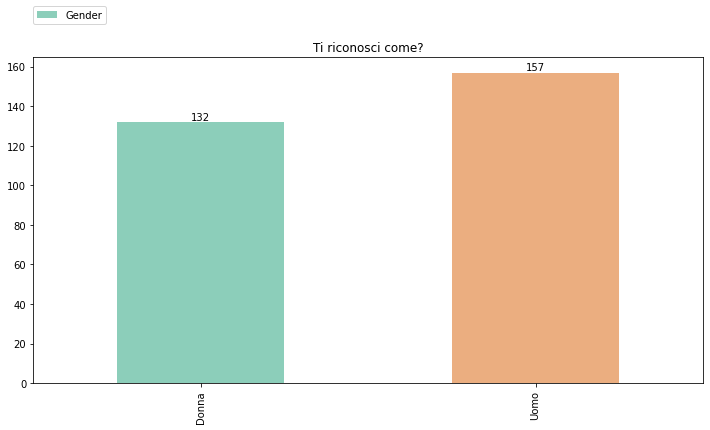

In [9]:
bar_plot(columns=["Gender"], title="Ti riconosci come?", filename="gender-distribution.pdf")

**Age-range Distribution** in Survey

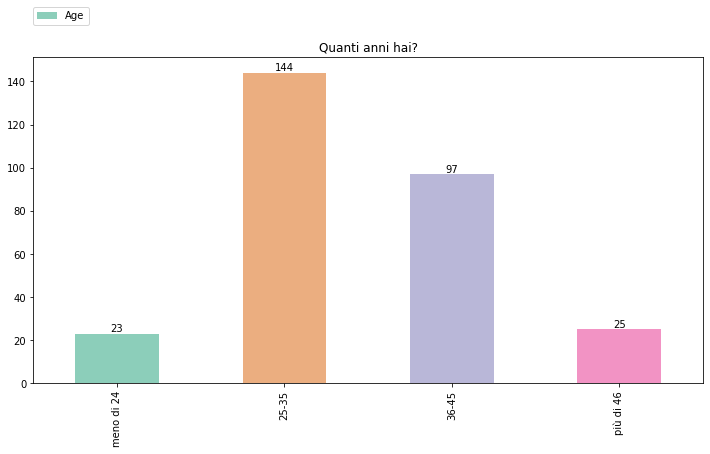

In [10]:
bar_plot(columns=["Age"], title="Quanti anni hai?", filename="age-distribution.pdf")

**Age distribution** (Stratified by `Gender`)

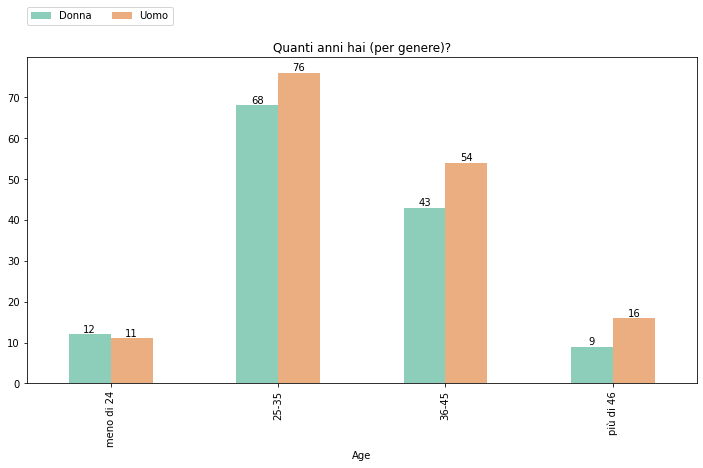

In [11]:
bar_plot(columns=["Gender", "Age"], unstack_ord=(0, ), title="Quanti anni hai (per genere)?", filename="age-gender-distribution.pdf")

**IT Role**

Categorical Type on IT Role (simplifying entries in Survey)

In [12]:
def role_group_cat(value):
    value = value.strip().lower()
    if "stud" in value:
        return "Student"
    if "dev" in value or "sviluppatore" in value or "programmer" in value:
        return "Developer"
    if "manager" in value or "professor" in value:
        return "Manager/Professor"
    if "engineer" in value or "cloud" in value:
        return "Engineer"
    if "data" in value or "analista" in value or "ricercatore" in value:
        return "Data Science"
    if "help desk" in value or "consulente" in value:
        return "Non-Dev"
    if value in ("qa", "digital strategist", "legal", "event assistant", "responsabile della comunicazione in una software house","web designer"):
        return "Non-Dev"
    if "disoccupata" in value:
        return "Other"

role_cat_type = CategoricalDtype(categories=["Student", "Developer", "Engineer", "Data Science", "Manager/Professor", "Non-Dev", "Other"], ordered=True)
answers["role_group"] = answers.Role.apply(role_group_cat).astype(role_cat_type)

In [13]:
answers.role_group.unique().tolist()

['Developer',
 'Manager/Professor',
 'Data Science',
 'Student',
 'Non-Dev',
 'Other',
 'Engineer']

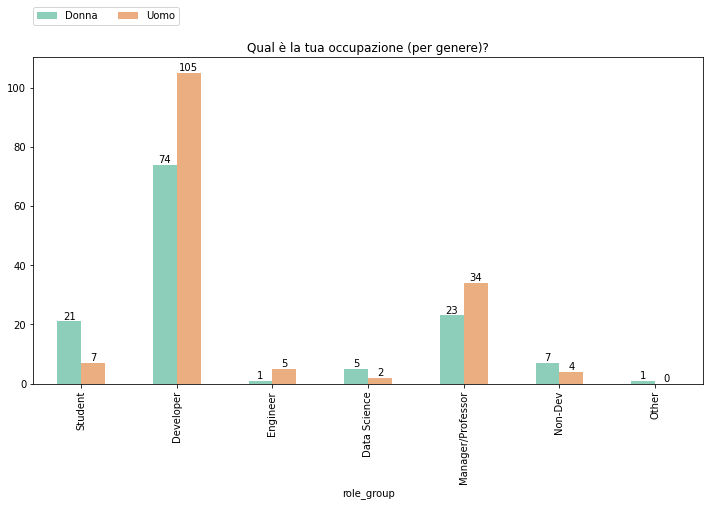

In [14]:
bar_plot(columns=["Gender", "role_group"], unstack_ord=(0, ), title="Qual è la tua occupazione (per genere)?", filename="role-gender-distribution.pdf")

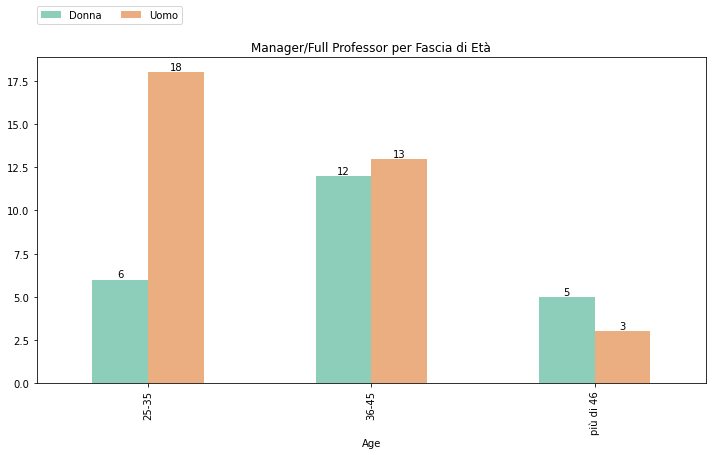

In [15]:
bar_plot(columns=["Gender", "Age"], selection=answers.role_group == "Manager/Professor",
         unstack_ord=(0, ),
         title="Manager/Full Professor per Fascia di Età", filename="gender-manager-age.pdf")

**Employment State** (Stratified by Gender)

In [16]:
def employment(value):
    value = value.strip().lower()
    if value == "non lavoro":
        return "disoccupato"
    else:
        return "occupato"

answers["employment"] = answers.Company.apply(employment).astype("category")

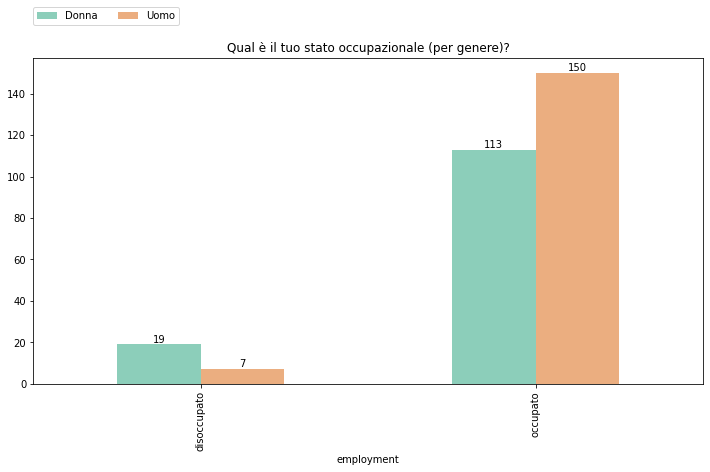

In [17]:
bar_plot(columns=["Gender", "employment"], unstack_ord=(0, ), title="Qual è il tuo stato occupazionale (per genere)?", filename="gender-occupation.pdf")

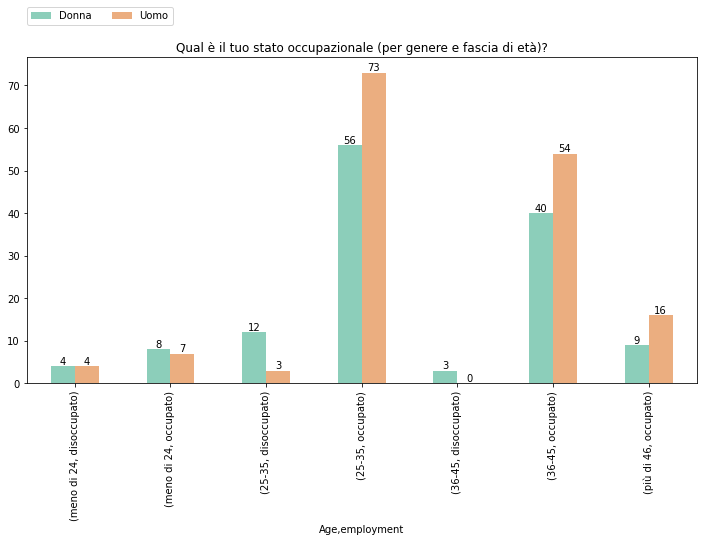

In [18]:
bar_plot(columns=["Gender", "Age", "employment"], unstack_ord=(0, ),
         title="Qual è il tuo stato occupazionale (per genere e fascia di età)?",
         filename="gender-age-occupation.pdf")

**Motivations** Analysed per Gender and Age Range

Participants were asked what were their motivation to join their path in Computer Science and Engineering. 
Multiple choices were possible, along with a completely open `Other` answer.

Therefore, all _unique_ motivations found in the dataset will be analysed and counted for each participant.

In [19]:
motivation_entries = answers.Motivation.values.tolist()

In [20]:
from itertools import chain

# multiple choices are comma-separated in the dataset.
motivation_values = set(chain.from_iterable(map(lambda v: v.split(", "), map(str.lower, motivation_entries))))
# map each motivation to a single index
motivation_map = {k.strip():i for i, k in enumerate(motivation_values)}

print(f"Total nr. of unique answers as for Motivations: {len(motivation_map)}")

Total nr. of unique answers as for Motivations: 20


In [21]:
import numpy as np

def map_motivation_values(entries: str):
    """Map each sample to their list of motivations - spiking a one whenever that motivation was specified"""
    values = np.zeros(shape=len(motivation_map), dtype=int)
    motivations = entries.strip().lower().split(", ")
    for m in motivations:
        values[motivation_map[m]] = 1
    return values

motivations_mapped = np.vstack(answers.Motivation.map(map_motivation_values)).T

In [22]:
motivations_mapped.shape

(20, 289)

In [23]:
motivations_data = {"Gender": answers.Gender.values, "Age": answers.Age.values, "role_group": answers.role_group.values}
motivations_data.update(zip(motivation_map.keys(), motivations_mapped))
motivations_df = pd.DataFrame(motivations_data)

In [24]:
motivations_df.shape

(289, 23)

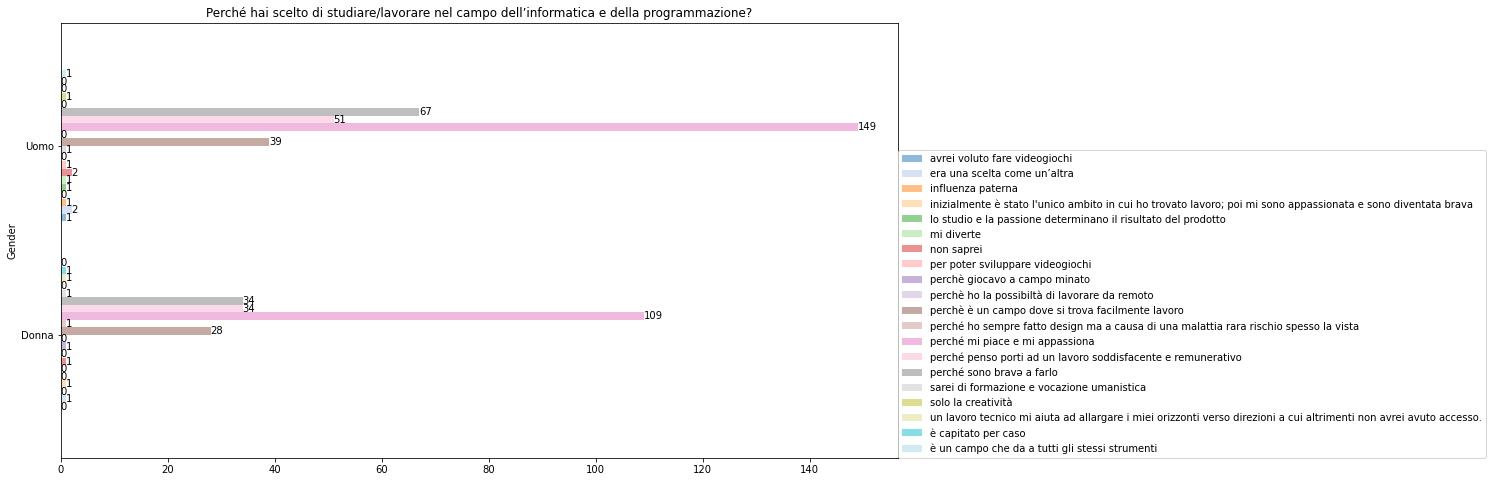

In [25]:
tab20 = plt.get_cmap("tab20")
bar_plot(columns=motivations_df.columns.difference(["role_group", "Age"]).tolist(), df=motivations_df, 
         aggregate="sum", groupby_cols=["Gender",], 
         colors=tab20.colors, horizontal=True,
         figsize=(15, 8), width=0.8, title="Perché hai scelto di studiare/lavorare nel campo dell’informatica e della programmazione?",
         filename="gender-motivations.pdf")

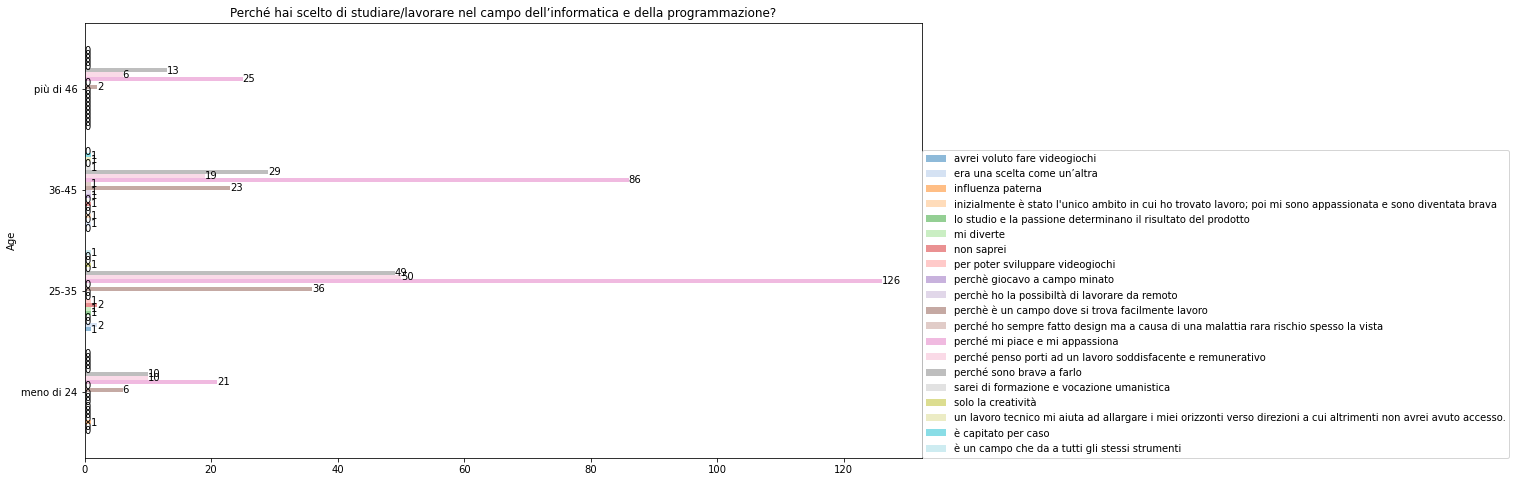

In [26]:
bar_plot(columns=motivations_df.columns.difference(["role_group", "Gender"]).tolist(), df=motivations_df, 
         aggregate="sum", groupby_cols=["Age",], 
         colors=tab20.colors, horizontal=True,
         figsize=(15, 8), width=0.8, title="Perché hai scelto di studiare/lavorare nel campo dell’informatica e della programmazione?",
         filename="age-motivations.pdf")

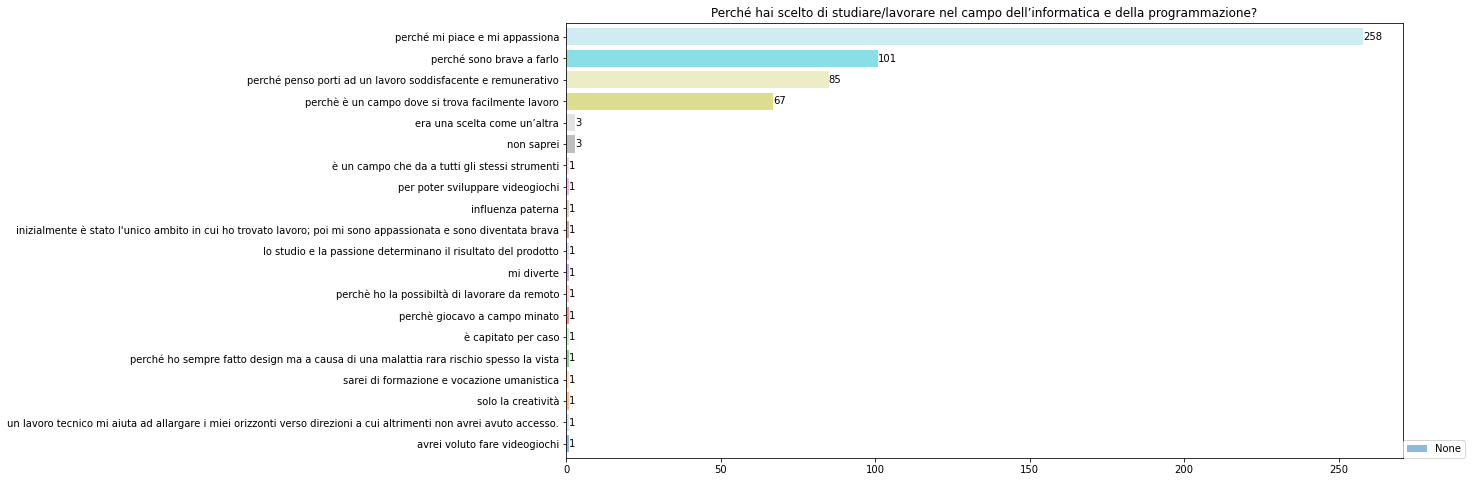

In [27]:
bar_plot(columns=motivations_df.columns.difference(["role_group", "Age", "Gender"]).tolist(), df=motivations_df, 
         aggregate="sum", sorted="values",
         colors=tab20.colors, horizontal=True,
         figsize=(15, 8), width=0.8, title="Perché hai scelto di studiare/lavorare nel campo dell’informatica e della programmazione?",
         filename="all-motivations.pdf")

**Discrimination** and **Gender-Gap**

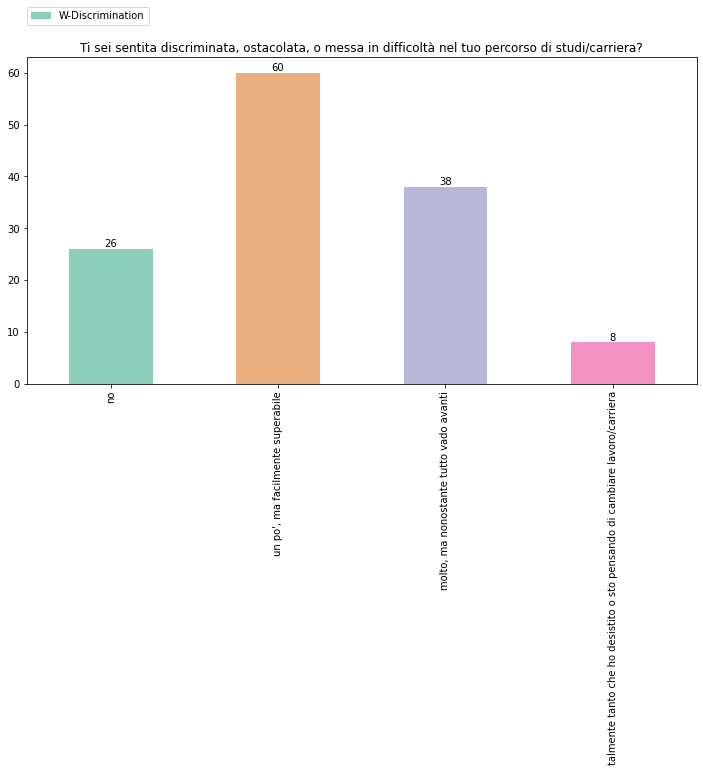

In [28]:
bar_plot(columns=["W-Discrimination"], selection=answers.Gender == "Donna", 
         title="Ti sei sentita discriminata, ostacolata, o messa in difficoltà nel tuo percorso di studi/carriera?", filename="discrimination-women.pdf")

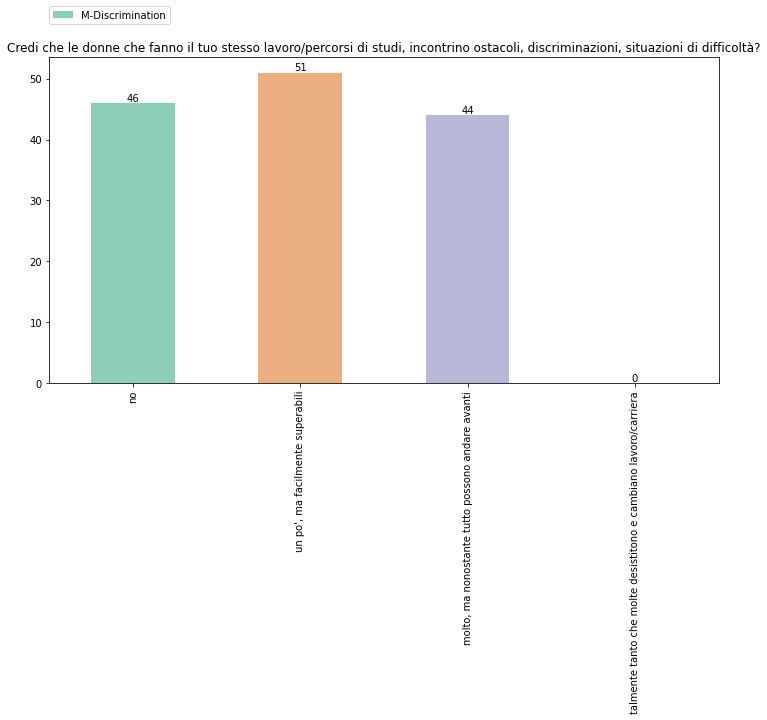

In [29]:
bar_plot(columns=["M-Discrimination"], selection=answers.Gender == "Uomo", 
         title="Credi che le donne che fanno il tuo stesso lavoro/percorsi di studi, incontrino ostacoli, discriminazioni, situazioni di difficoltà?", filename="discrimination-men.pdf")

**FIX Gender Gap**?

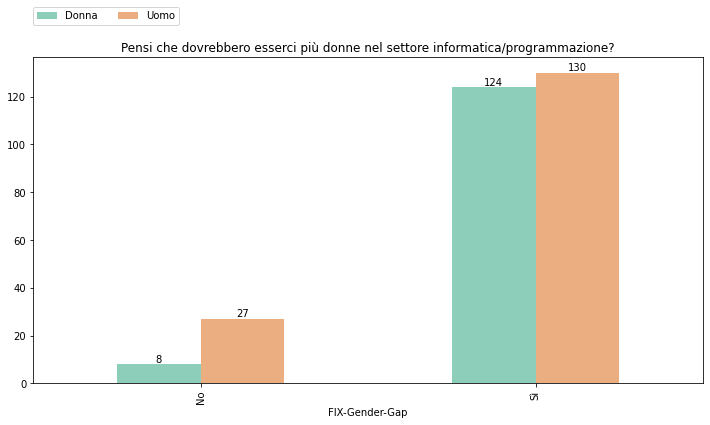

In [30]:
bar_plot(columns=["Gender", "FIX-Gender-Gap"], unstack_ord=(0, ),
         title="Pensi che dovrebbero esserci più donne nel settore informatica/programmazione?", filename="gender-gap.pdf")